<a href="https://colab.research.google.com/github/pierresegonne/COMP5328_Project2/blob/master/pierre.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# IMPORTS

In [1]:
# Install pytorch FOR GOOGLE COLAB
from os import path
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())

accelerator = 'cu80' if path.exists('/opt/bin/nvidia-smi') else 'cpu'
print('Accelerator: ', accelerator)

print('Installing Torch') 
!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-1.0.0-{platform}-linux_x86_64.whl
# Issue with torchvision version
!pip install torchvision==0.2.1
import torch
import torchvision

Accelerator:  cu80
Installing Torch
     |████████████████████████████████| 532.5MB 36.1MB/s 
ERROR: torchvision 0.4.1+cu100 has requirement torch==1.3.0, but you'll have torch 1.0.0 which is incompatible.
     |████████████████████████████████| 61kB 2.0MB/s 
  Found existing installation: torchvision 0.4.1+cu100
    Uninstalling torchvision-0.4.1+cu100:
      Successfully uninstalled torchvision-0.4.1+cu100


In [0]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pickle
import torch
import torchvision
import torch.nn.functional as F
import torch.optim as optim

from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA
from sklearn.linear_model import SGDClassifier
from sklearn.manifold import TSNE
from torch import nn
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler, TensorDataset

# UTILS

In [0]:
ROOT_DIRECTORY = '.'

In [4]:
# Allow saving files to google drive if ran on colab
from google.colab import drive
drive.mount('/content/gdrive')
ROOT_DIRECTORY = '/content/gdrive/My Drive/Colab Notebooks/COMP5328 Project2'

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
def show_grid_images(images, title=''):
    """
    From a list of images,
    Plots all images along a kx5 grid.
    """
    nbr_images = images.shape[0]
    figsize_ref = 0.5
    rows, columns = int(nbr_images / 5), 5
    f = plt.figure(figsize=(figsize_ref*columns,figsize_ref*rows)) # 2 Columns, . Lines
    plt.axis('off')
    plt.title(title,  y=1.08) # Trick to offset the title.
    plt.subplots_adjust(wspace=-0.35, hspace=0)
    for index in range(nbr_images):
        image = images[index]
        ax = f.add_subplot(rows, columns, index + 1)
        ax.axis('off')
        ax.imshow(image, cmap=plt.cm.gray)
    
    plt.show()
    
def get_priors(Y):
    priors = []
    classes = set(Y)
    masked = [i for i in Y]
    for c in classes:
        class_mask = (Y == c)
        priors.append(len(Y[class_mask]) / len(Y))
    return priors

def serialize_object(obj, file_name):
  with open(file_name, 'wb') as file_handler:
    pickle.dump(obj, file_handler, protocol=pickle.HIGHEST_PROTOCOL)

def read_pickled(file_name):
  pickled_data = {}
  if os.path.getsize(file_name) > 0:      
    with open(file_name, "rb") as f:
      unpickler = pickle.Unpickler(f)
      pickled_data = unpickler.load()
  return pickled_data

# LOADING DATASETS

In [0]:
def load_dataset(dataset_name, path='{}/data/'.format(ROOT_DIRECTORY)):
    dataset = np.load(f'{path}{dataset_name}')
    X_train, Y_train = dataset['Xtr'], dataset['Str']
    X_test, Y_test = dataset['Xts'], dataset['Yts']
    
    return X_train, Y_train, X_test, Y_test

### ======================

In [302]:
MNIST_05_NAME = 'FashionMNIST0.5.npz'
MNIST_06_NAME = 'FashionMNIST0.6.npz'
CIFAR_NAME = 'CIFAR.npz'

mnist05_X_train, mnist05_Y_train, mnist05_X_test, mnist05_Y_test = load_dataset(MNIST_05_NAME)
print('Fashion MNIST 0.5 dataset, X_train shape: {}, X_test shape: {}, Classes in Y: {}'.format(mnist05_X_train.shape, mnist05_X_test.shape, set(mnist05_Y_train)))
mnist06_X_train, mnist06_Y_train, mnist06_X_test, mnist06_Y_test = load_dataset(MNIST_06_NAME)
print('Fashion MNIST 0.6 dataset, X_train shape: {}, X_test shape: {}, Classes in Y: {}'.format(mnist06_X_train.shape, mnist06_X_test.shape, set(mnist06_Y_train)))
cifar_X_train, cifar_Y_train, cifar_X_test, cifar_Y_test = load_dataset(CIFAR_NAME)
print('Fashion CIFAR dataset, X_train shape: {}, X_test shape: {}, Classes in Y: {}'.format(cifar_X_train.shape, cifar_X_test.shape, set(cifar_Y_train)))


Fashion MNIST 0.5 dataset, X_train shape: (18000, 28, 28), X_test shape: (3000, 28, 28), Classes in Y: {0, 1, 2}
Fashion MNIST 0.6 dataset, X_train shape: (18000, 28, 28), X_test shape: (3000, 28, 28), Classes in Y: {0, 1, 2}
Fashion CIFAR dataset, X_train shape: (15000, 32, 32, 3), X_test shape: (3000, 32, 32, 3), Classes in Y: {0, 1, 2}


In [8]:
# Transitions Matrices
mnist05_X_T = np.array([
    [0.5, 0.3, 0.2],
    [0.2, 0.5, 0.3],
    [0.3, 0.2, 0.5]
])

mnist06_X_T = np.array([
    [0.4, 0.3, 0.4],
    [0.4, 0.4, 0.3],
    [0.3, 0.3, 0.4]
])

# Priors
mnist05_priors = get_priors(mnist05_Y_test)
mnist05_noisy_priors = get_priors(mnist05_Y_train)

mnist06_priors = get_priors(mnist06_Y_test)
mnist06_noisy_priors = get_priors(mnist06_Y_train)

cifar_priors = get_priors(cifar_Y_test)
cifar_noisy_priors = get_priors(cifar_Y_train)

print(f'Priors for MNIST 05, true labels: {mnist05_priors}, noisy labels: {mnist05_noisy_priors}')
print(f'Priors for MNIST 06, true labels: {mnist06_priors}, noisy labels: {mnist06_noisy_priors}')
print(f'Priors for CIFAR, true labels: {cifar_priors}, noisy labels: {cifar_noisy_priors}')

Priors for MNIST 05, true labels: [0.3333333333333333, 0.3333333333333333, 0.3333333333333333], noisy labels: [0.3333333333333333, 0.3333333333333333, 0.3333333333333333]
Priors for MNIST 06, true labels: [0.3333333333333333, 0.3333333333333333, 0.3333333333333333], noisy labels: [0.3333333333333333, 0.3333333333333333, 0.3333333333333333]
Priors for CIFAR, true labels: [0.3333333333333333, 0.3333333333333333, 0.3333333333333333], noisy labels: [0.3333333333333333, 0.3333333333333333, 0.3333333333333333]


## Image Visualization

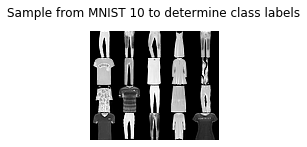

Associated Labels
[[1 1 1 2 1]
 [0 1 0 2 2]
 [2 0 1 2 1]
 [0 1 1 2 0]]


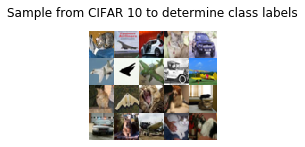

Associated Labels
[[2 0 1 2 1]
 [0 0 0 1 0]
 [2 0 2 2 2]
 [1 2 0 2 2]]


In [13]:
# Determine the association between class index and label from samples

nbr_examples = 20
show_grid_images(mnist05_X_test[:nbr_examples], 'Sample from MNIST 10 to determine class labels')
print('Associated Labels')
print(mnist05_Y_test[:nbr_examples].reshape(-1,5))

nbr_examples = 20
show_grid_images(cifar_X_test[:nbr_examples], 'Sample from CIFAR 10 to determine class labels')
print('Associated Labels')
print(cifar_Y_test[:nbr_examples].reshape(-1,5))

In [0]:
mnist_classes = ['t-shirt', 'trousers', 'dress']
cifar_classes = ['plane', 'car', 'cat']

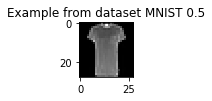

Associated Class: t-shirt


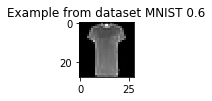

Associated Class: t-shirt


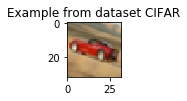

Associated Class: car


In [15]:
# From test to avoid label noise

# Fashion MNIST 0.5
plt.figure(figsize=(1,1))
plt.imshow(mnist05_X_test[66], cmap=plt.cm.gray)
plt.title('Example from dataset MNIST 0.5')
plt.show()
print(f'Associated Class: {mnist_classes[mnist05_Y_test[66]]}')


# Fashion MNIST 0.6
plt.figure(figsize=(1,1))
plt.imshow(mnist06_X_test[66], cmap=plt.cm.gray)
plt.title('Example from dataset MNIST 0.6')
plt.show()
print(f'Associated Class: {mnist_classes[mnist06_Y_test[66]]}')

# Fashion CIFAR
plt.figure(figsize=(1,1))
plt.imshow(cifar_X_test[66], cmap=plt.cm.gray)
plt.title('Example from dataset CIFAR')
plt.show()
print(f'Associated Class: {cifar_classes[cifar_Y_test[66]]}')

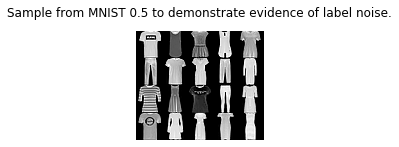

Associated Labels
[['dress' 'trousers' 'dress' 'trousers' 'dress']
 ['t-shirt' 'trousers' 't-shirt' 'trousers' 't-shirt']
 ['trousers' 'trousers' 'trousers' 'dress' 'dress']
 ['t-shirt' 'dress' 'dress' 'dress' 'dress']]


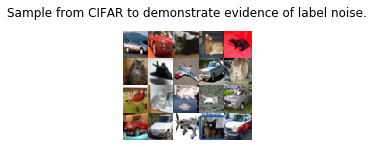

Associated Labels
[['car' 'cat' 'plane' 'cat' 'car']
 ['plane' 'plane' 'plane' 'car' 'plane']
 ['cat' 'cat' 'plane' 'plane' 'car']
 ['car' 'cat' 'plane' 'car' 'car']]


In [16]:
# Show evidence of label noise

nbr_examples = 20
show_grid_images(mnist05_X_train[:nbr_examples], 'Sample from MNIST 0.5 to demonstrate evidence of label noise.')
print('Associated Labels')
print(np.array([mnist_classes[mnist05_Y_train[i]] for i in range(nbr_examples)]).reshape(-1,5))

show_grid_images(cifar_X_train[:nbr_examples], 'Sample from CIFAR to demonstrate evidence of label noise.')
print('Associated Labels')
print(np.array([cifar_classes[cifar_Y_train[i]] for i in range(nbr_examples)]).reshape(-1,5))

## Resizing datasets

This transforms the datasets fron NxWxH to NxWH

In [0]:
# MNIST 0.5
mnist_image_size = [28, 28]
mnist05_X_train_2d = mnist05_X_train.reshape(-1, np.prod(mnist_image_size))
mnist05_X_test_2d = mnist05_X_test.reshape(-1, np.prod(mnist_image_size))

# MNIST 0.6
mnist06_X_train_2d = mnist06_X_train.reshape(-1, np.prod(mnist_image_size))
mnist06_X_test_2d = mnist06_X_test.reshape(-1, np.prod(mnist_image_size))

# CIFAR
cifar_image_size = [3, 32, 32]
cifar_X_train_2d = cifar_X_train.reshape(-1, np.prod(cifar_image_size))
cifar_X_test_2d = cifar_X_test.reshape(-1, np.prod(cifar_image_size))

#  CLASSIFICATION

In [0]:
# Using SK Learn for validation of idea
clf = SGDClassifier(loss='log', alpha=0.3) # modified_huber
clf.fit(mnist05_X_train, mnist05_Y_train)

SGDClassifier(alpha=0.3, average=False, class_weight=None, early_stopping=False,
              epsilon=0.1, eta0=0.0, fit_intercept=True, l1_ratio=0.15,
              learning_rate='optimal', loss='log', max_iter=1000,
              n_iter_no_change=5, n_jobs=None, penalty='l2', power_t=0.5,
              random_state=None, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

In [0]:
noisy_probas = clf.predict_proba(mnist05_X_train)
true_probas = noisy_probas@np.linalg.pinv(mnist05_X_T).T
predicted_classes = np.argmax(true_probas, axis=1) # flipped classes
p_classes = clf.predict(mnist05_X_train) # original classes

accuracy(mnist05_Y_train, p_classes), accuracy(mnist05_Y_train, predicted_classes)

(45.6, 44.88333333333333)

# FLIP

# EVALUATION

In [0]:
def accuracy(true_labels, predicted_labels):
    correct = 0
    for i in range(len(true_labels)):
        if true_labels[i] == predicted_labels[i]:
            correct += 1
    return correct / len(true_labels) * 100
        

In [0]:
accuracy(mnist05_Y_train, clf.predict(mnist05_X_train)), accuracy(mnist05_Y_test, clf.predict(mnist05_X_test))

(45.6, 59.13333333333334)

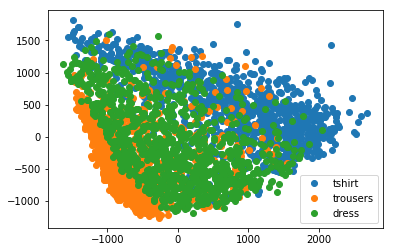

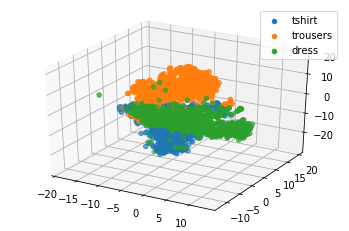

In [0]:
# TEST PCA & TSNE
pca = PCA(n_components=2)
pca_outputs = pca.fit_transform(mnist05_X_test, mnist05_Y_test)

tshirt_mask = (mnist05_Y_test == 0)
pca_tshirt = pca_outputs[tshirt_mask]

trousers_mask = (mnist05_Y_test == 1)
pca_trousers = pca_outputs[trousers_mask]

dress_mask = (mnist05_Y_test == 2)
pca_dress = pca_outputs[dress_mask]

plt.figure()
plt.plot(pca_tshirt[:,0],pca_tshirt[:,1], 'o')
plt.plot(pca_trousers[:,0],pca_trousers[:,1], 'o')
plt.plot(pca_dress[:,0],pca_dress[:,1], 'o')
plt.legend(['tshirt', 'trousers', 'dress'])
plt.show()


tsne = TSNE(n_components=3, verbose=0, perplexity=40, n_iter=1000)
tsne_outputs = tsne.fit_transform(mnist05_X_test, mnist05_Y_test)

tsne_tshirt = tsne_outputs[tshirt_mask]

tsne_trousers = tsne_outputs[trousers_mask]

tsne_dress = tsne_outputs[dress_mask]

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(tsne_tshirt[:,0], tsne_tshirt[:,1], tsne_tshirt[:,2])
ax.scatter(tsne_trousers[:,0], tsne_trousers[:,1], tsne_trousers[:,2])
ax.scatter(tsne_dress[:,0], tsne_dress[:,1], tsne_dress[:,2])
ax.legend(['tshirt', 'trousers', 'dress'])
plt.show()

# Label Noise Robust NN

In [50]:
# Utils
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('The training will run on __ {} __'.format(device))

# Preprocessing
def grayscale_to_rgb(grayscale_dataset):
    """
    input dim: NxWxH
    output dim: NxWxHx3
    """
    return np.stack((grayscale_dataset,)*3, axis=-1)

def resize(X, image_size):
    resized_X = np.zeros((X.shape[0], image_size[0], image_size[1], X.shape[-1]))
    for i in range(X.shape[0]):
        resized_X[i, :, :, :] = cv2.resize(X[i, :, :, :], image_size, interpolation = cv2.INTER_AREA)
    return resized_X

def swap_channel_axis(X):
    """
    input dim: NxWxHx3
    output dim: Nx3xWxH
    """
    return np.swapaxes(X, -1, 1)

def normalize_per_channel(X):
    """
    input dim: Nx3xWxH
    """
    means, stds = [], []
    for channel in range(X.shape[1]):
        mean, std = X[:, channel, :, :].mean(), X[:, channel, :, :].std()
        X[:, channel, :, :] = (X[:, channel, :, :] - mean) / std
        means.append(mean)
        stds.append(std)
    return X, {"mean": means, "std": stds}
        
def unnormalize(x, mean, std):
    x = x * np.array(std).reshape(x.shape[0], 1, 1) + np.array(mean).reshape(x.shape[0], 1, 1)
    return x

def showimg(tensor, normalization=None):
    npimg = tensor.numpy()
    if normalization:
        npimg = unnormalize(npimg, normalization['mean'], normalization['std'])
    plt.figure(figsize=(15,10))
    plt.imshow((np.transpose(npimg, (1, 2, 0))* 255).astype(np.uint8))
    plt.show()
    
class Evaluation(object):
    
    def __init__(self):
        self.loss = []
        self.accuracy = []

    
class Recordings():
    
    def __init__(self, progress_recording_frequency, evaluation_recording_frequency):
        self.progress = []
        self.evaluation = Evaluation()
        self.progress_recording_frequency = progress_recording_frequency
        self.evaluation_recording_frequency = evaluation_recording_frequency
    
    def log_progress(self, epoch, epochs, iteration, iterations):
        print(f'\n---- Epoch {epoch + 1}/{epochs}, Iteration {iteration + 1}/{iterations}')
        print('Loss : {:.4f}'.format(self.progress[-1]))

    def log_evaluation(self, epoch, epochs):
        print(f'\n----- Recording of Evaluation for epoch {epoch + 1}/{epochs}')
        print('Loss: {:.4f}, Accuracy: {:.4f}'.format(self.evaluation.loss[-1], self.evaluation.accuracy[-1]))
        
    def display(self):
        iterations_axes = [i * self.progress_recording_frequency for i in range(len(self.progress))]

        # Progress Loss
        fig, (ax1) = plt.subplots(1, 1, figsize=(18, 4))
        ax1.plot(iterations_axes, self.progress, color='darkslategray')
        fig.suptitle('Progress Loss')
        ax1.set(xlabel='Iterations', ylabel='Loss')
        plt.show()

        iterations_axes = [i * self.evaluation_recording_frequency for i in range(len(self.evaluation.loss))]

        # Evaluation Metrics
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 4))
        ax1.plot(iterations_axes, self.evaluation.loss, color='darkslategray')
        ax1.set(xlabel='Epochs', ylabel='Loss')
        ax2.plot(iterations_axes, self.evaluation.accuracy, color='darkslategray')
        ax2.set(xlabel='Epochs', ylabel='Accuracy')
        fig.suptitle('Evaluation Metrics Recording')
        plt.show()






The training will run on __ cuda __


In [0]:
# Data Loaders

# MNIST 05
mnist05_X_train_rgb = grayscale_to_rgb(mnist05_X_train)
mnist05_X_train_rgb = resize(mnist05_X_train_rgb, (32, 32))
mnist05_X_train_rgb = swap_channel_axis(mnist05_X_train_rgb)
mnist05_train_set = TensorDataset(torch.from_numpy(mnist05_X_train_rgb), torch.from_numpy(mnist05_Y_train))

mnist05_X_test_rgb = grayscale_to_rgb(mnist05_X_test)
mnist05_X_test_rgb = resize(mnist05_X_test_rgb, (32, 32))
mnist05_X_test_rgb = swap_channel_axis(mnist05_X_test_rgb)
mnist05_test_set = TensorDataset(torch.from_numpy(mnist05_X_test_rgb), torch.from_numpy(mnist05_Y_test))


# MNIST 06
mnist06_X_train_rgb = grayscale_to_rgb(mnist06_X_train)
mnist06_X_train_rgb = resize(mnist06_X_train_rgb, (32, 32))
mnist06_X_train_rgb = swap_channel_axis(mnist06_X_train_rgb)
mnist06_train_set = TensorDataset(torch.from_numpy(mnist06_X_train_rgb), torch.from_numpy(mnist06_Y_train))

mnist06_X_test_rgb = grayscale_to_rgb(mnist06_X_test)
mnist06_X_test_rgb = resize(mnist06_X_test_rgb, (32, 32))
mnist06_X_test_rgb = swap_channel_axis(mnist06_X_test_rgb)
mnist06_test_set = TensorDataset(torch.from_numpy(mnist06_X_test_rgb), torch.from_numpy(mnist06_Y_test))


# CIFAR
cifar_X_train = swap_channel_axis(cifar_X_train)
cifar_train_set = TensorDataset(torch.from_numpy(cifar_X_train), torch.from_numpy(cifar_Y_train))

cifar_X_test = swap_channel_axis(cifar_X_test)
cifar_test_set = TensorDataset(torch.from_numpy(cifar_X_test), torch.from_numpy(cifar_Y_test))

 ---- MNIST 05 Samples
trousers dress dress t-shirt t-shirt t-shirt trousers dress dress dress dress trousers dress t-shirt


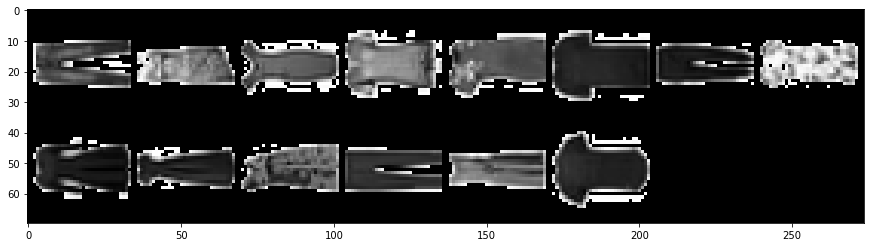

In [52]:
# Visualization test
mnist05_test_loader = DataLoader(mnist05_test_set, batch_size=14, shuffle=True)
dataiter = mnist05_test_loader.__iter__()
input, labels = dataiter.next()
print(' ---- MNIST 05 Samples')
print(' '.join('%5s' % mnist_classes[labels[j]] for j in range(14)))
showimg(torchvision.utils.make_grid(input), normalization=None)

In [0]:
# Split training into training and validation
def get_training_validation_samplers(trainset, validation_proportion=0.2):
    indices = np.arange(len(trainset))
    np.random.shuffle(indices)
    split = int((1 - validation_proportion) * len(trainset))

    train_sampler, validation_sampler = SubsetRandomSampler(indices[:split]), SubsetRandomSampler(indices[split:])

    return train_sampler, validation_sampler

mnist05_train_sampler, mnist05_validation_sampler = get_training_validation_samplers(mnist05_train_set)
mnist06_train_sampler, mnist06_validation_sampler = get_training_validation_samplers(mnist06_train_set)
cifar_train_sampler, cifar_validation_sampler = get_training_validation_samplers(cifar_train_set)

In [53]:
# Model structure

class CNN(nn.Module):

    def __init__(self, number_classes=10):
        super(CNN, self).__init__()
        
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=5, stride=1, padding=0), # 28
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2), # 14
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1), # 14
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2), # 7
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=0), # 5
            nn.ReLU(inplace=True)
        )
        
        self.classifier = nn.Sequential(
            nn.Linear(5*5*128, 1024),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(1024, 1024),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(1024, number_classes),
        ) # No softmax because CrossEntropy loss does it.

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), 128 * 5 * 5)
        x = self.classifier(x)
        return x
    
TEST_INPUT = True
if TEST_INPUT:
    cnn_test = CNN().to(device)
    INPUT_SIZE = (3, 32, 32)
    input_random = torch.rand((1, INPUT_SIZE[0], INPUT_SIZE[1], INPUT_SIZE[2])).to(device)
    print('Forward Test\n', cnn_test(input_random))

Forward Test
 tensor([[-0.0087, -0.0382,  0.0178, -0.0039, -0.0194,  0.0186,  0.0283, -0.0179,
         -0.0331,  0.0320]], device='cuda:0', grad_fn=<AddmmBackward>)


In [0]:
# Training and Evaluation

def evaluate(model, loader, device):
    # Eval flag
    model.eval()

    # Initialize metrics
    loss = 0.
    accuracy = 0.
    
    # Criterion
    criterion = nn.CrossEntropyLoss()
    
    with torch.no_grad():
        for (inputs, labels) in loader:
            # To device
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            # Prediction
            label_outputs = model(inputs.float())

            # Update loss
            loss += criterion(label_outputs, labels).data.item()

            # Update Accuracies
            predicted_labels = label_outputs.data.max(1)[1]
            accuracy += predicted_labels.eq(labels.data).sum().item()

    # Average metrics
    loss /= len(loader)
    accuracy /= len(loader.dataset)

    return loss, accuracy


def train(model, optimizer, criterion, dataset, device, params, inverse_transition_matrix=None):
    print('==== Start Training ====')
    # Train Flag
    model.train()
    
    # Recordings
    recordings = Recordings(params.log_progress_every, params.evaluate_model_every)

    # Number of classes
    nbr_classes = len(set(dataset.tensors[1].numpy()))

    # Type casting for inverse transition matrix
    if inverse_transition_matrix is not None:
        inverse_transition_matrix = inverse_transition_matrix.float()
    
    for epoch in range(params.epochs):

        # For shuffling, regenerate the dataloaders
        t_sampler, v_sampler = get_training_validation_samplers(mnist05_train_set)
        t_loader = DataLoader(dataset, batch_size=params.batch_size, sampler=t_sampler)
        v_loader = DataLoader(dataset, batch_size=params.batch_size, sampler=v_sampler)

        
        for iteration, (inputs, labels) in enumerate(t_loader):
            # Prepare to device
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            # Reset grad
            optimizer.zero_grad()

            # Outputs
            output_labels = model(inputs.float())

            # Loss
            if inverse_transition_matrix is not None:
                unique_labels = [c * torch.ones(labels.size()[0]).long().to(device) for c in range(nbr_classes)]
                losses = [criterion(output_labels, l) for l in unique_labels]
                losses = torch.stack(losses)
                corrected_losses = (inverse_transition_matrix@losses).transpose(0,1)
                loss = corrected_losses.gather(1, labels.view(-1,1)).mean()
            else:
                loss = criterion(output_labels, labels).mean()

            # Optimize
            loss.backward()
            optimizer.step()
            
            # =======
            # Log Progress
            if ((iteration + 1) % params.log_progress_every == 0):
                recordings.progress.append(loss.data.item())
                recordings.log_progress(epoch, params.epochs, iteration, len(t_loader))
        
        # Evaluate
        if ((epoch + 1) % params.evaluate_model_every == 0):
            evaluation_loss, evaluation_accuracy = evaluate(model, v_loader, device)
            recordings.evaluation.loss.append(evaluation_loss); recordings.evaluation.accuracy.append(evaluation_accuracy)

            recordings.log_evaluation(epoch, params.epochs)

        # Save temporary model
        if ((epoch + 1) % params.save_model_every == 0):
            torch.save(model.state_dict(), params.model_filename)
    
    # Save final model
    torch.save(model.state_dict(), params.model_filename)

    # Save recordings
    serialize_object(recordings, params.recordings_filename)

    print('==== End Training ====')
    
    return model, recordings
        
        
        
        

In [0]:
class Params(object):
    batch_size = 252
    epochs = 15
    learning_rate = 0.01
    momentum = 0.9
    weight_decay = 0
    
    log_progress_every = 25 # in iterations
    evaluate_model_every = 1 # in epochs

    save_model_every = 25 # in epochs
    model_filename = '{}/saves/model.pth'.format(ROOT_DIRECTORY)
    recordings_filename = '{}/saves/recordings.pickle'.format(ROOT_DIRECTORY)

params = Params()
model = CNN(number_classes=3).to(device).float()
optimizer = optim.SGD(model.parameters(), lr=params.learning_rate, momentum=params.momentum, weight_decay=params.weight_decay)
criterion = nn.CrossEntropyLoss(reduction='none')

# ====================================
# Loaders
mnist05_train_loader = DataLoader(mnist05_train_set, batch_size=params.batch_size, sampler=mnist05_train_sampler)
mnist05_validation_loader = DataLoader(mnist05_train_set, batch_size=params.batch_size, sampler=mnist05_validation_sampler)
mnist05_test_loader = DataLoader(mnist05_test_set, batch_size=params.batch_size, shuffle=False)

mnist06_train_loader = DataLoader(mnist06_train_set, batch_size=params.batch_size, sampler=mnist06_train_sampler)
mnist06_validation_loader = DataLoader(mnist06_train_set, batch_size=params.batch_size, sampler=mnist06_validation_sampler)
mnist06_test_loader = DataLoader(mnist06_test_set, batch_size=params.batch_size, shuffle=False)

cifar_train_loader = DataLoader(cifar_train_set, batch_size=params.batch_size, sampler=cifar_train_sampler)
cifar_validation_loader = DataLoader(cifar_train_set, batch_size=params.batch_size, sampler=cifar_validation_sampler)
cifar_test_loader = DataLoader(cifar_test_set, batch_size=params.batch_size, shuffle=False)

# ====================================
# Choose dataset and Transition Matrix
train_loader, validation_loader, test_loader = cifar_train_loader, cifar_validation_loader, cifar_test_loader
dataset = cifar_train_set
inverse_transition_matrix = None # torch.from_numpy(mnist05_X_T.T).to(device) # Transpose for inverse transition

In [368]:
model, recordings = train(model, optimizer, criterion, dataset, device, params, inverse_transition_matrix=inverse_transition_matrix)

==== Start Training ====


IndexError: ignored

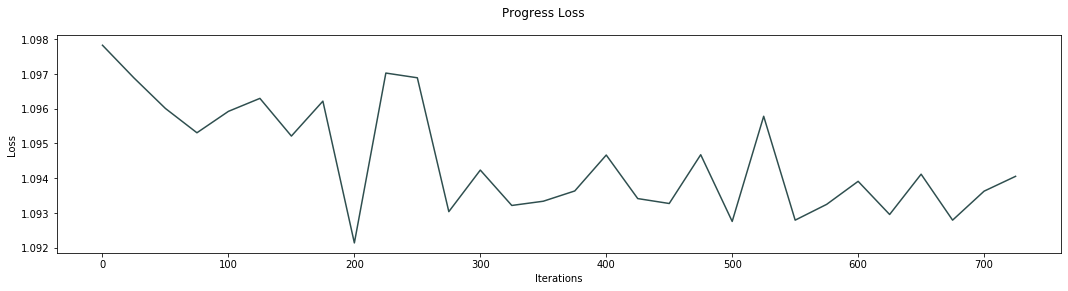

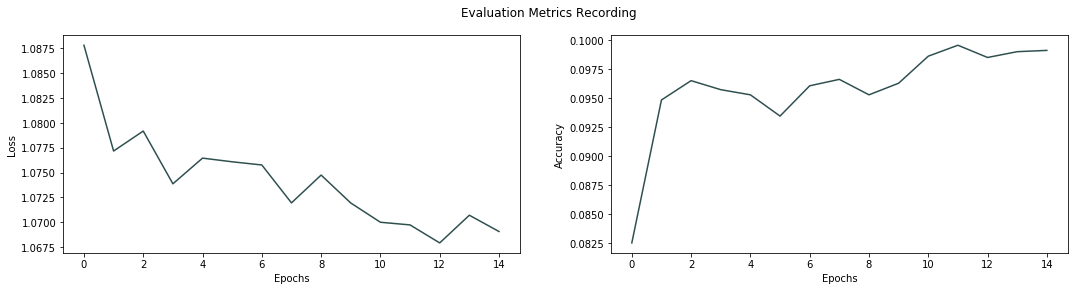

In [361]:
recordings.display()

## Estimation of the flip matrix

In [362]:
# First, find the xi
nbr_classes = len(set(train_loader.dataset.tensors[1].numpy()))
nbr_train_samples = len((train_loader.dataset.tensors[1].numpy()))

x_i = []
softmax = nn.Softmax(dim=1)
with torch.no_grad():
    model.eval()
    all_outputs_train = model(train_loader.dataset.tensors[0].float().to(device)).cpu().numpy()
    all_outputs_test = model(test_loader.dataset.tensors[0].float().to(device)).cpu().numpy()

all_outputs = np.concatenate((all_outputs_train, all_outputs_test))
x_i_indices = np.argmax(all_outputs, axis=0)

estimated_transition_matrix = np.zeros((nbr_classes,nbr_classes))
with torch.no_grad():
    model.eval()
    for i, index in enumerate(x_i_indices):
        if index < nbr_train_samples:
            p_i = softmax(model(train_loader.dataset.tensors[0][index].float().to(device).view(1, 3, 32, 32)))
        else:
            test_index = index - nbr_train_samples
            p_i = softmax(model(train_loader.dataset.tensors[0][test_index].float().to(device).view(1, 3, 32, 32)))
        estimated_transition_matrix[i,:] = p_i.cpu().numpy()[0]

estimated_transition_matrix

array([[0.43343115, 0.28647211, 0.2800968 ],
       [0.32495558, 0.35009629, 0.32494813],
       [0.29073861, 0.29062504, 0.41863641]])

Test

In [363]:
loss, accuracy = evaluate(model, test_loader, device)

loss, accuracy

(1.0043364067872365, 0.9266666666666666)

==== Start Training ====

---- Epoch 1/10, Iteration 25/58
Loss : 1.3070

---- Epoch 1/10, Iteration 50/58
Loss : 1.4495

----- Recording of Evaluation for epoch 1/10
Loss: 1.1275, Accuracy: 0.0689

---- Epoch 2/10, Iteration 25/58
Loss : 1.0896

---- Epoch 2/10, Iteration 50/58
Loss : 1.0797

----- Recording of Evaluation for epoch 2/10
Loss: 1.1230, Accuracy: 0.0707

---- Epoch 3/10, Iteration 25/58
Loss : 1.1004

---- Epoch 3/10, Iteration 50/58
Loss : 1.1013

----- Recording of Evaluation for epoch 3/10
Loss: 1.1223, Accuracy: 0.0716

---- Epoch 4/10, Iteration 25/58
Loss : 1.1026

---- Epoch 4/10, Iteration 50/58
Loss : 1.0887

----- Recording of Evaluation for epoch 4/10
Loss: 1.1215, Accuracy: 0.0716

---- Epoch 5/10, Iteration 25/58
Loss : 1.1047

---- Epoch 5/10, Iteration 50/58
Loss : 1.1049

----- Recording of Evaluation for epoch 5/10
Loss: 1.1320, Accuracy: 0.0672

---- Epoch 6/10, Iteration 25/58
Loss : 1.0945

---- Epoch 6/10, Iteration 50/58
Loss : 1.1021

----- Recordi

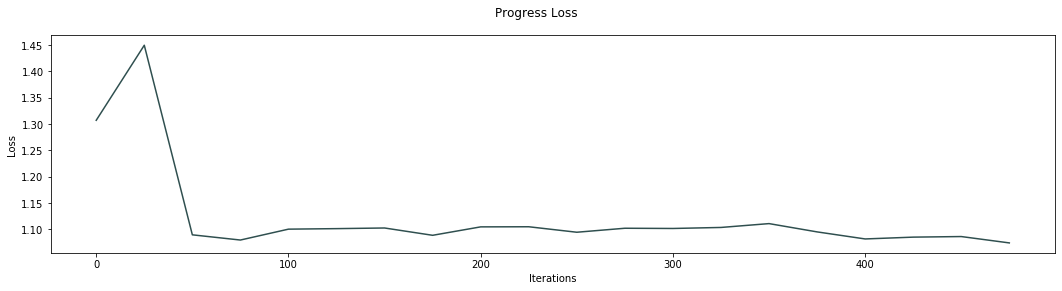

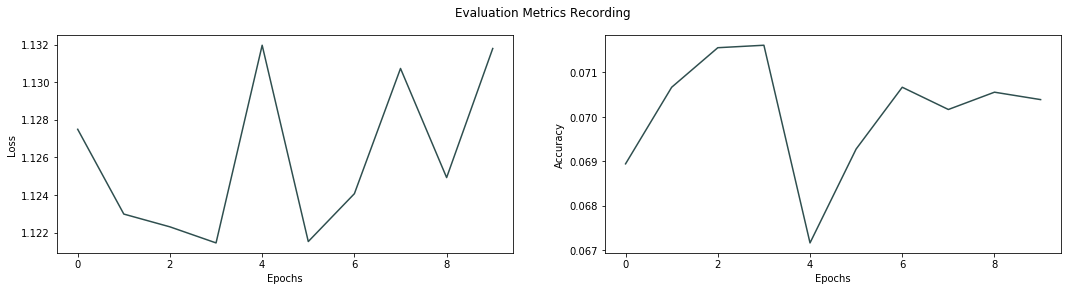

(1.012417991956075, 0.4146666666666667)

In [235]:
# Adjust Params
params.epochs = 10

# Run
model = CNN(number_classes=3).to(device).float()
model, recordings = train(model, optimizer, criterion, dataset, device, params, inverse_transition_matrix=torch.from_numpy(estimated_transition_matrix.T).to(device))
recordings.display()
loss, accuracy = evaluate(model, test_loader, device)
loss, accuracy

 ---- MNIST 05 Samples
True      | trousers |dress |dress |dress |t-shirt |trousers |trousers |dress |dress |trousers |trousers |trousers |t-shirt |t-shirt
Predicted | dress |t-shirt |t-shirt |dress |dress |t-shirt |dress |t-shirt |dress |trousers |t-shirt |trousers |t-shirt |t-shirt


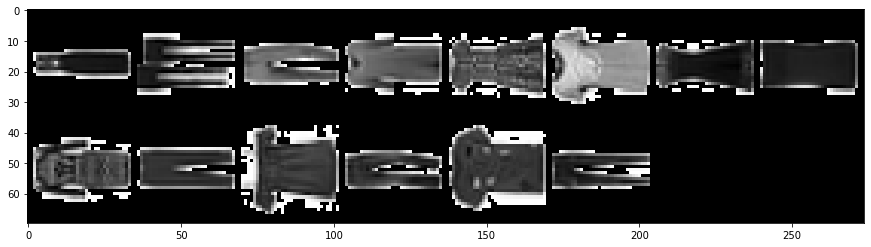

In [168]:
# Visualization test
visualization_loader = DataLoader(mnist05_train_set, batch_size=14, shuffle=True)
dataiter = visualization_loader.__iter__()
inputs, labels = dataiter.next()
with torch.no_grad():
    predicted_labels = model(inputs.to(device).float()).data.max(1)[1]
print(' ---- MNIST 05 Samples')
print('True      |', ' |'.join('%5s' % mnist_classes[labels[j]] for j in range(14)))
print('Predicted |', ' |'.join('%5s' % mnist_classes[predicted_labels[j]] for j in range(14)))
showimg(torchvision.utils.make_grid(inputs), normalization=None)

tensor([[ 0.0318, -0.0726,  0.0517],
        [ 0.0922, -0.3841,  0.3043],
        [-0.0474,  0.0957, -0.0228],
        [ 0.2277, -0.1475, -0.0829],
        [-0.1009,  0.1726, -0.0504],
        [-0.0860, -0.0085,  0.1028],
        [-0.0505,  0.1498, -0.0626],
        [ 0.1207, -0.3477,  0.2441],
        [ 0.3699, -0.1161, -0.2882],
        [ 0.1636, -0.1409, -0.0346],
        [ 0.0381, -0.4203,  0.4063],
        [ 0.0009, -0.4204,  0.4092],
        [ 0.1539, -0.2406,  0.0887],
        [ 0.1801, -0.2996,  0.1417]], device='cuda:0')
tensor([[ 0.0045, -0.0145,  0.0209],
        [-0.0083, -0.0823,  0.1030],
        [ 0.0004,  0.0315, -0.0065],
        [ 0.0530, -0.0531, -0.0026],
        [-0.0088,  0.0510, -0.0210],
        [-0.0250,  0.0094,  0.0239],
        [ 0.0071,  0.0460, -0.0165],
        [ 0.0048, -0.0765,  0.0887],
        [ 0.0925, -0.0706, -0.0564],
        [ 0.0326, -0.0481,  0.0036],
        [-0.0258, -0.0807,  0.1305],
        [-0.0438, -0.0872,  0.1208],
        [ 0.0225, -0

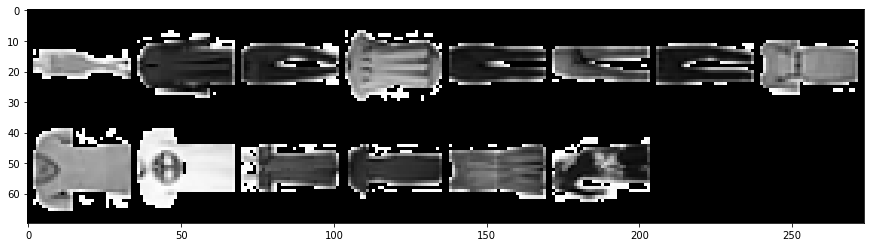

In [175]:
# Test of the backward operation
t_matrix = torch.from_numpy(mnist05_X_T).to(device)

inputs, labels = dataiter.next()
with torch.no_grad():
    outputs = model(inputs.to(device).float())
    print(outputs)
    corrected_outputs = (t_matrix.float()@outputs.transpose(0,1)).transpose(0,1)
    print(corrected_outputs)
    
    predicted_labels_nc = outputs.data.max(1)[1]
    predicted_labels_c = corrected_outputs.data.max(1)[1]

print(' ---- MNIST 05 Samples')
print('True          |', ' |'.join('%5s' % mnist_classes[labels[j]] for j in range(14)))
print('No Correction |', ' |'.join('%5s' % mnist_classes[predicted_labels_nc[j]] for j in range(14)))
print('Correction    |', ' |'.join('%5s' % mnist_classes[predicted_labels_c[j]] for j in range(14)))
showimg(torchvision.utils.make_grid(inputs), normalization=None)

In [314]:
# Test

l = np.array([0.8960, 1.2253, 1.2102]).T
mnist05_X_T.T@l

array([1.05612, 1.12349, 1.15189])